In [1]:
# Load datasets from saved pickle files
import pandas as pd
import os

import os, json, pickle, random, time

import xgboost as xgb
import numpy as np
from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import (
    precision_recall_curve, auc,
    accuracy_score
)


In [2]:
def load_history(path):
    if os.path.exists(path):
        return pickle.load(open(path,'rb'))
    return {
        'tried_params': {},
        'best': {
            'params':     None,
            'pr_auc':     0.0,
            'acc_test':   0.0,
            'model_path': None
        }
    }

def save_history(history, path):
    d = os.path.dirname(path)
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)
    pickle.dump(history, open(path,'wb'))

def sample_params(space, spw):
    return {
        'n_estimators':        random.randint(*space['n_estimators']),
        'learning_rate':       random.uniform(*space['learning_rate']),
        'max_depth':           random.randint(*space['max_depth']),
        'subsample':           random.uniform(*space['subsample']),
        'colsample_bytree':    random.uniform(*space['colsample_bytree']),
        'scale_pos_weight':    spw,
        'objective':           'binary:logistic',
        'eval_metric':         'aucpr',
        'random_state':        42,
        'early_stopping_rounds': 50
    }

def encode_and_spw(y_train):
    le   = LabelEncoder().fit(y_train)
    y_enc= le.transform(y_train)
    neg, pos = np.bincount(y_enc).max(), np.bincount(y_enc).min()
    return le, neg/pos

def train_and_pr(params, X_tr, y_tr, X_val, y_val):
    model = xgb.XGBClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    p_val = model.predict_proba(X_val)[:,1]
    prec, rec, _ = precision_recall_curve(y_val, p_val)
    return model, auc(rec, prec)

def test_acc(params, model, X_te, y_te):
    p_te = model.predict_proba(X_te)[:,1]
    return accuracy_score(y_te, (p_te>=0.5).astype(int))

def random_search_xgb_pr(
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    param_space,
    results_path,
    best_model_bin
):
    history = load_history(results_path)
    le, spw = encode_and_spw(y_train)
    y_tr   = le.transform(y_train)
    y_vale = le.transform(y_val)
    y_te   = le.transform(y_test)

    iteration = 0
    try:
        while True:
            iteration += 1
            params = sample_params(param_space, spw)
            key    = json.dumps(params, sort_keys=True)
            if key in history['tried_params']:
                continue

            # 1) train & get val PR‐AUC
            model, pr_val = train_and_pr(params,
                                         X_train, y_tr,
                                         X_val,   y_vale)
            # 2) measure test accuracy
            acc_te = test_acc(params, model, X_test, y_te)

            # record it
            history['tried_params'][key] = {
                'pr_val': pr_val,
                'acc_te': acc_te,
                'time':   time.time()
            }

            # 3) select if both pr_val ↑ and acc_te ≥ previous
            best = history['best']
            better_pr = pr_val > best['pr_auc']
            tie_pr    = pr_val == best['pr_auc']
            better_acc= acc_te > best['acc_test']
            not_worse_acc = acc_te >= best['acc_test']

            if (better_pr and not_worse_acc) or (tie_pr and better_acc):
                history['best'] = {
                    'params':     params,
                    'pr_auc':     pr_val,
                    'acc_test':   acc_te,
                    'model_path': best_model_bin
                }
                os.makedirs(os.path.dirname(best_model_bin) or '.', exist_ok=True)
                model.save_model(best_model_bin)
                print(f"[Iter {iteration}] 🎉 New best pr_val={pr_val:.4f}, acc_test={acc_te:.4f}")
                print("            params =", params)

            save_history(history, results_path)

    except KeyboardInterrupt:
        save_history(history, results_path)
        b = history['best']
        print("\n🔸 Interrupted — best so far:")
        print(f"   pr_val   = {b['pr_auc']:.4f}")
        print(f"   acc_test = {b['acc_test']:.4f}")
        print(f"   params   = {b['params']}")
        print(f"   model    = {b['model_path']}")

# ————————————————————————————————————————————————
# USAGE

PARAM_SPACE = {
    'n_estimators':     (20, 200),
    'learning_rate':    (0.01, 0.3),
    'max_depth':        (2, 30),
    'subsample':        (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
}

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import (
    accuracy_score, f1_score,
    precision_score, recall_score,
    roc_auc_score, roc_curve,
    precision_recall_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)
from sklearn.calibration      import CalibratedClassifierCV

def evaluate_with_auto_threshold(
    model,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    calibrate: bool = True,
    calibrator_method: str = 'sigmoid'
):
    """
    1) Fit LabelEncoder on y_train.
    2) (Optional) Calibrate model on (X_val, y_val).
    3) Find threshold on val that maximizes F1.
    4) Print metrics & classification reports for Val & Test.
    5) Then show all plots (ROC, PR, Confusion Matrices, Importances).
    """
    # --- Encode labels ---
    le = LabelEncoder().fit(y_train)
    y_val_enc, y_test_enc = le.transform(y_val), le.transform(y_test)

    # --- Calibrate if requested ---
    if calibrate:
        calibrator = CalibratedClassifierCV(
            estimator=model, method=calibrator_method, cv='prefit'
        )
        calibrator.fit(X_val, y_val_enc)
        proba_val  = calibrator.predict_proba(X_val)[:,1]
        proba_test = calibrator.predict_proba(X_test)[:,1]
    else:
        proba_val  = model.predict_proba(X_val)[:,1]
        proba_test = model.predict_proba(X_test)[:,1]

    # --- Find best threshold on validation by F1 ---
    thresholds = np.linspace(0, 1, 101)
    f1_scores  = [f1_score(y_val_enc, (proba_val >= t).astype(int)) for t in thresholds]
    best_idx   = np.argmax(f1_scores)
    best_thr   = thresholds[best_idx]
    print(f"→ Selected threshold = {best_thr:.2f} (F1 on val = {f1_scores[best_idx]:.4f})\n")

    # --- Function to compute & print metrics & report ---
    def print_metrics(y_true_enc, proba, split_name):
        y_pred = (proba >= best_thr).astype(int)
        acc    = accuracy_score(y_true_enc, y_pred)
        prec   = precision_score(y_true_enc, y_pred)
        rec    = recall_score(y_true_enc, y_pred)
        f1     = f1_score(y_true_enc, y_pred)
        rocauc = roc_auc_score(y_true_enc, proba)
        pr_auc = auc(*precision_recall_curve(y_true_enc, proba)[1::-1])

        print(f"{split_name} results @ t={best_thr:.2f}")
        print(f"  Accuracy : {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall   : {rec:.4f}")
        print(f"  F1-Score : {f1:.4f}")
        print(f"  ROC AUC  : {rocauc:.4f}")
        print(f"  PR AUC   : {pr_auc:.4f}\n")
        print(classification_report(
            le.inverse_transform(y_true_enc),
            le.inverse_transform(y_pred),
            target_names=le.classes_
        ))
        print("-" * 50 + "\n")

    # --- Print Val and Test metrics & reports ---
    print_metrics(y_val_enc,  proba_val,  "Validation")
    print_metrics(y_test_enc, proba_test, "Test")

    # --- Now all the plots: ---
    # 1) Confusion Matrices
    for proba, name in [(proba_val, "Validation"), (proba_test, "Test")]:
        y_pred = (proba >= best_thr).astype(int)
        cm = confusion_matrix(
            le.inverse_transform(le.transform(y_val if name=="Validation" else y_test)),
            le.inverse_transform(y_pred),
            labels=le.classes_
        )
        disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
        plt.figure(figsize=(5,5))
        disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
        plt.title(f"{name} Confusion Matrix")
        plt.show()

    # 2) ROC curves
    fpr_v, tpr_v, _ = roc_curve(y_val_enc,  proba_val)
    fpr_t, tpr_t, _ = roc_curve(y_test_enc, proba_test)
    plt.figure()
    plt.plot(fpr_v, tpr_v, label=f"Val ROC (AUC={roc_auc_score(y_val_enc, proba_val):.3f})")
    plt.plot(fpr_t, tpr_t, label=f"Test ROC (AUC={roc_auc_score(y_test_enc, proba_test):.3f})")
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

    # 3) Precision–Recall curves
    prec_v, rec_v, _ = precision_recall_curve(y_val_enc,  proba_val)
    prec_t, rec_t, _ = precision_recall_curve(y_test_enc, proba_test)
    plt.figure()
    plt.plot(rec_v, prec_v, label=f"Val PR (AUC={auc(rec_v,prec_v):.3f})")
    plt.plot(rec_t, prec_t, label=f"Test PR (AUC={auc(rec_t,prec_t):.3f})")
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('Precision–Recall Curves')
    plt.legend(loc='lower left')
    plt.show()

    # 4) Top-20 feature importances
    plt.figure(figsize=(8,6))
    xgb.plot_importance(model, max_num_features=20)
    plt.title('Top 20 Feature Importances')
    plt.show()

In [4]:
# Check if files exist in the outputs directory
if os.path.exists('outputs/X_train_B.pkl'):
    # Load the required datasets for the model training
    X_train_B = pd.read_pickle('outputs/X_train_B.pkl')
    y_train_B = pd.read_pickle('outputs/y_train_B.pkl')
    X_val_B = pd.read_pickle('outputs/X_val_B.pkl')
    y_val_B = pd.read_pickle('outputs/y_val_B.pkl')
    X_test_B = pd.read_pickle('outputs/X_test_B.pkl')
    y_test_B = pd.read_pickle('outputs/y_test_B.pkl')
    
    print(f"Loaded datasets from pickle files:")
    print(f"X_train_B shape: {X_train_B.shape}")
    print(f"X_val_B shape: {X_val_B.shape}")
    print(f"X_test_B shape: {X_test_B.shape}")
    
    # Define paths for results
    RESULTS_PATH = 'outputs/xgb_pr_search_B.pkl'
    BEST_MODEL_BIN = 'outputs/xgb_pr_best_model_B.bin'
    
    # Now call the random search function with the loaded data
    random_search_xgb_pr(
        X_train_B, y_train_B,
        X_val_B, y_val_B,
        X_test_B, y_test_B,
        param_space=PARAM_SPACE,
        results_path=RESULTS_PATH,
        best_model_bin=BEST_MODEL_BIN
    )
else:
    print("Error: Dataset files not found in 'outputs/' directory.")
    print("Please ensure you've saved the datasets first using the to_pickle method.")

Loaded datasets from pickle files:
X_train_B shape: (12023, 217)
X_val_B shape: (6454, 217)
X_test_B shape: (6505, 217)


/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


[Iter 1] 🎉 New best pr_val=0.9791, acc_test=0.7772
            params = {'n_estimators': 76, 'learning_rate': 0.13928207750109642, 'max_depth': 3, 'subsample': 0.9278611009830304, 'colsample_bytree': 0.5018196372067862, 'scale_pos_weight': 2.698246693325131, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': 42, 'early_stopping_rounds': 50}


/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


[Iter 3] 🎉 New best pr_val=0.9810, acc_test=0.7816
            params = {'n_estimators': 157, 'learning_rate': 0.140361055238723, 'max_depth': 4, 'subsample': 0.5978379759160509, 'colsample_bytree': 0.8616657202886135, 'scale_pos_weight': 2.698246693325131, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': 42, 'early_stopping_rounds': 50}


/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:48:50] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


[Iter 14] 🎉 New best pr_val=0.9837, acc_test=0.7866
            params = {'n_estimators': 41, 'learning_rate': 0.11230222269306385, 'max_depth': 2, 'subsample': 0.7276311882501573, 'colsample_bytree': 0.8310083119351716, 'scale_pos_weight': 2.698246693325131, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': 42, 'early_stopping_rounds': 50}

🔸 Interrupted — best so far:
   pr_val   = 0.9837
   acc_test = 0.7866
   params   = {'n_estimators': 41, 'learning_rate': 0.11230222269306385, 'max_depth': 2, 'subsample': 0.7276311882501573, 'colsample_bytree': 0.8310083119351716, 'scale_pos_weight': 2.698246693325131, 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': 42, 'early_stopping_rounds': 50}
   model    = outputs/xgb_pr_best_model_B.bin


→ Selected threshold = 0.22 (F1 on val = 0.9348)

Validation results @ t=0.22
  Accuracy : 0.8785
  Precision: 0.8807
  Recall   : 0.9959
  F1-Score : 0.9348
  ROC AUC  : 0.8897
  PR AUC   : 0.9837

              precision    recall  f1-score   support

        LVOT       0.70      0.07      0.12       814
        RVOT       0.88      1.00      0.93      5640

    accuracy                           0.88      6454
   macro avg       0.79      0.53      0.53      6454
weighted avg       0.86      0.88      0.83      6454

--------------------------------------------------

Test results @ t=0.22
  Accuracy : 0.7922
  Precision: 0.7878
  Recall   : 1.0000
  F1-Score : 0.8813
  ROC AUC  : 0.9172
  PR AUC   : 0.9747

              precision    recall  f1-score   support

        LVOT       1.00      0.09      0.16      1485
        RVOT       0.79      1.00      0.88      5020

    accuracy                           0.79      6505
   macro avg       0.89      0.54      0.52      6505
weighte

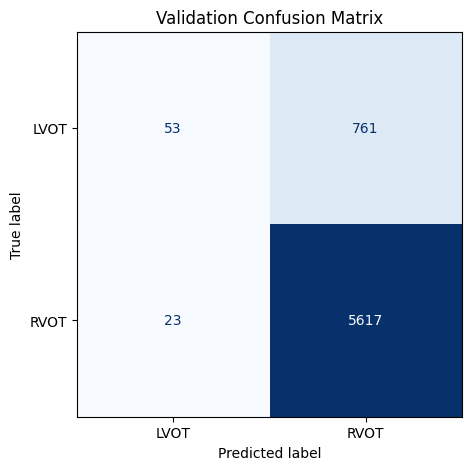

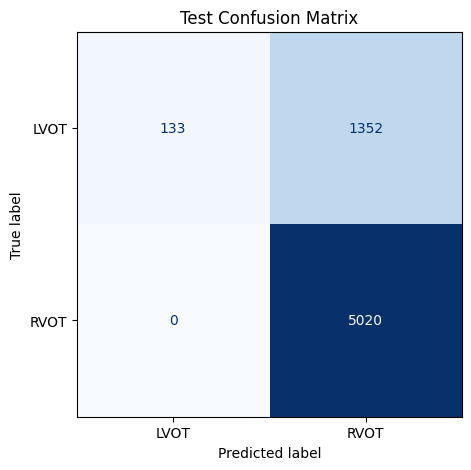

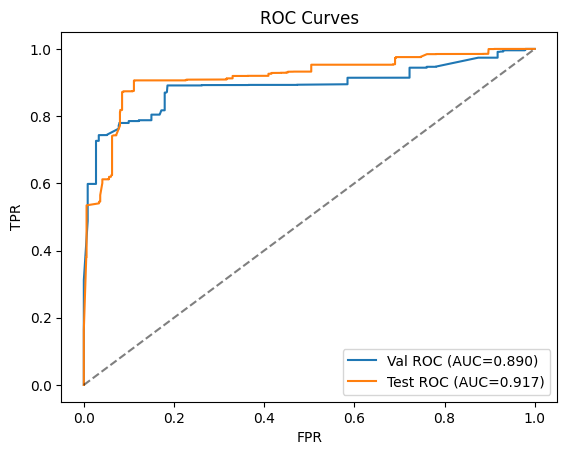

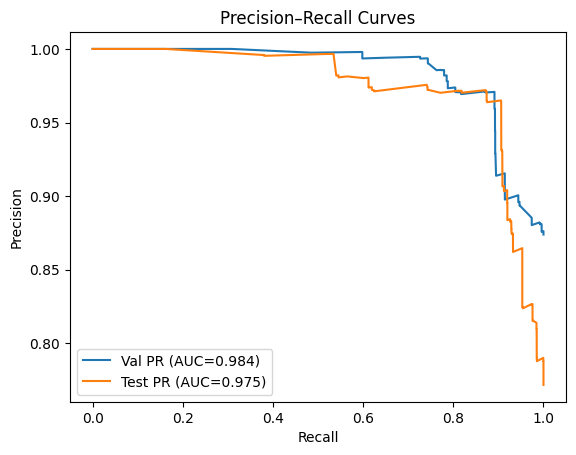

<Figure size 800x600 with 0 Axes>

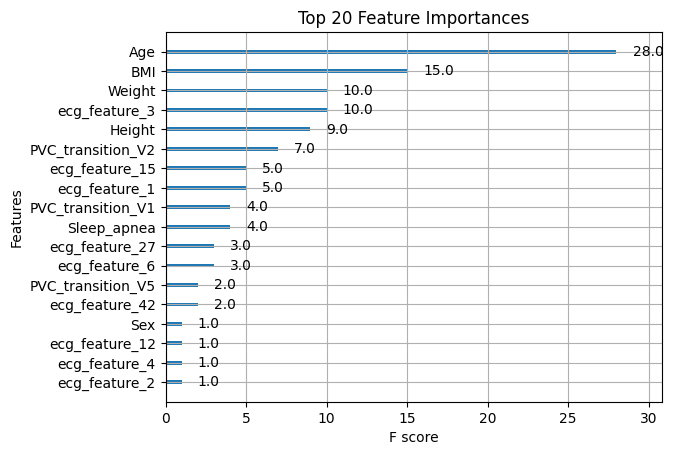

In [28]:
# load as before
best_model = xgb.XGBClassifier()
best_model.load_model('outputs/xgb_pr_best_model_B.bin')

evaluate_with_auto_threshold(
    best_model,
    X_train_B, y_train_B,
    X_val_B,   y_val_B,
    X_test_B,  y_test_B,
    calibrate=True,
    calibrator_method='sigmoid'
)